# Explaining maching learning
You can find in this notebook the exploratory data analysis done over the heart disease dataset, coupled with the simple machine learning algorithm used to predict the diseases.

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import warnings
from IPython.display import Image
from torch.utils.data import Dataset, SequentialSampler, DataLoader, WeightedRandomSampler, BatchSampler
from sklearn import metrics, preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import export_graphviz
from subprocess import call
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', 20)
warnings.filterwarnings('ignore')

/home/romain/Projects/explain-ml/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/romain/Projects/explain-ml/env/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Dataset fields description
1. age: age in years
2. sex: sex (1 = male; 0 = female)
3. cp: chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
4. trestbps: resting blood pressure (in mm Hg on admission to the 
    hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
7. restecg: resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak = ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
14. num: diagnosis of heart disease (angiographic disease status)
    - Value 0: < 50% diameter narrowing
    - Value 1: > 50% diameter narrowing
    (in any major vessel: attributes 59 through 68 are vessels)

## Loading the dataset
We load the dataset while replacing some values such as the `NaN` and `?`.

In [2]:
heart_df = pd.read_csv("../data/heart-disease/processed.cleveland.data", delimiter=",",
                       names=["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
                              "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"])
heart_df = heart_df.rename(columns={"cp":"chest_pain",
                                    "thalach":"max_heart_rate",
                                    "oldpeak":"st_dep_induced",
                                    "ca":"num_maj_ves"})

heart_df['num_bin'] = heart_df['num'].apply(lambda x: 1 if x > 0 else 0)

heart_df = heart_df.replace('?', np.nan)
heart_df = heart_df.dropna(axis=0, how="any")

heart_df[['num_maj_ves', 'thal']] = heart_df[['num_maj_ves', 'thal']].astype('float')
heart_df= heart_df.reset_index(drop=True)

heart_df.drop("num", inplace=True, axis=1)
heart_df.head()

age  sex  chest_pain  trestbps   chol  fbs  restecg  max_heart_rate  \
0  63.0  1.0         1.0     145.0  233.0  1.0      2.0           150.0   
1  67.0  1.0         4.0     160.0  286.0  0.0      2.0           108.0   
2  67.0  1.0         4.0     120.0  229.0  0.0      2.0           129.0   
3  37.0  1.0         3.0     130.0  250.0  0.0      0.0           187.0   
4  41.0  0.0         2.0     130.0  204.0  0.0      2.0           172.0   

   exang  st_dep_induced  slope  num_maj_ves  thal  num_bin  
0    0.0             2.3    3.0          0.0   6.0        0  
1    1.0             1.5    2.0          3.0   3.0        1  
2    1.0             2.6    2.0          2.0   7.0        1  
3    0.0             3.5    3.0          0.0   3.0        0  
4    0.0             1.4    1.0          0.0   3.0        0

## Statistical exploratory analysis
A quick exploratory analysis for us to understand the features better.

In [3]:
heart_df.describe()

age         sex  chest_pain    trestbps        chol         fbs  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean    54.542088    0.676768    3.158249  131.693603  247.350168    0.144781   
std      9.049736    0.468500    0.964859   17.762806   51.997583    0.352474   
min     29.000000    0.000000    1.000000   94.000000  126.000000    0.000000   
25%     48.000000    0.000000    3.000000  120.000000  211.000000    0.000000   
50%     56.000000    1.000000    3.000000  130.000000  243.000000    0.000000   
75%     61.000000    1.000000    4.000000  140.000000  276.000000    0.000000   
max     77.000000    1.000000    4.000000  200.000000  564.000000    1.000000   

          restecg  max_heart_rate       exang  st_dep_induced       slope  \
count  297.000000      297.000000  297.000000      297.000000  297.000000   
mean     0.996633      149.599327    0.326599        1.055556    1.602694   
std      0.994914       22.941562    0.469761        1.166123    0.618187   
min      0.000000       71.000000    0.000000        0.000000    1.000000   
25%      0.000000      133.000000    0.000000        0.000000    1.000000   
50%      1.000000      153.000000    0.000000        0.800000    2.000000   
75%      2.000000      166.000000    1.000000        1.600000    2.000000   
max      2.000000      202.000000    1.000000        6.200000    3.000000   

       num_maj_ves        thal     num_bin  
count   297.000000  297.000000  297.000000  
mean      0.676768    4.730640    0.461279  
std       0.938965    1.938629    0.499340  
min       0.000000    3.000000    0.000000  
25%       0.000000    3.000000    0.000000  
50%       0.000000    3.000000    0.000000  
75%       1.000000    7.000000    1.000000  
max       3.000000    7.000000    1.000000

### Plotting the dataset
The main reason for plotting some features is to get a feel of what each of them looks like, how they're distributed, in order to prevent any wrong assumptions, or to process the dataset better while training.

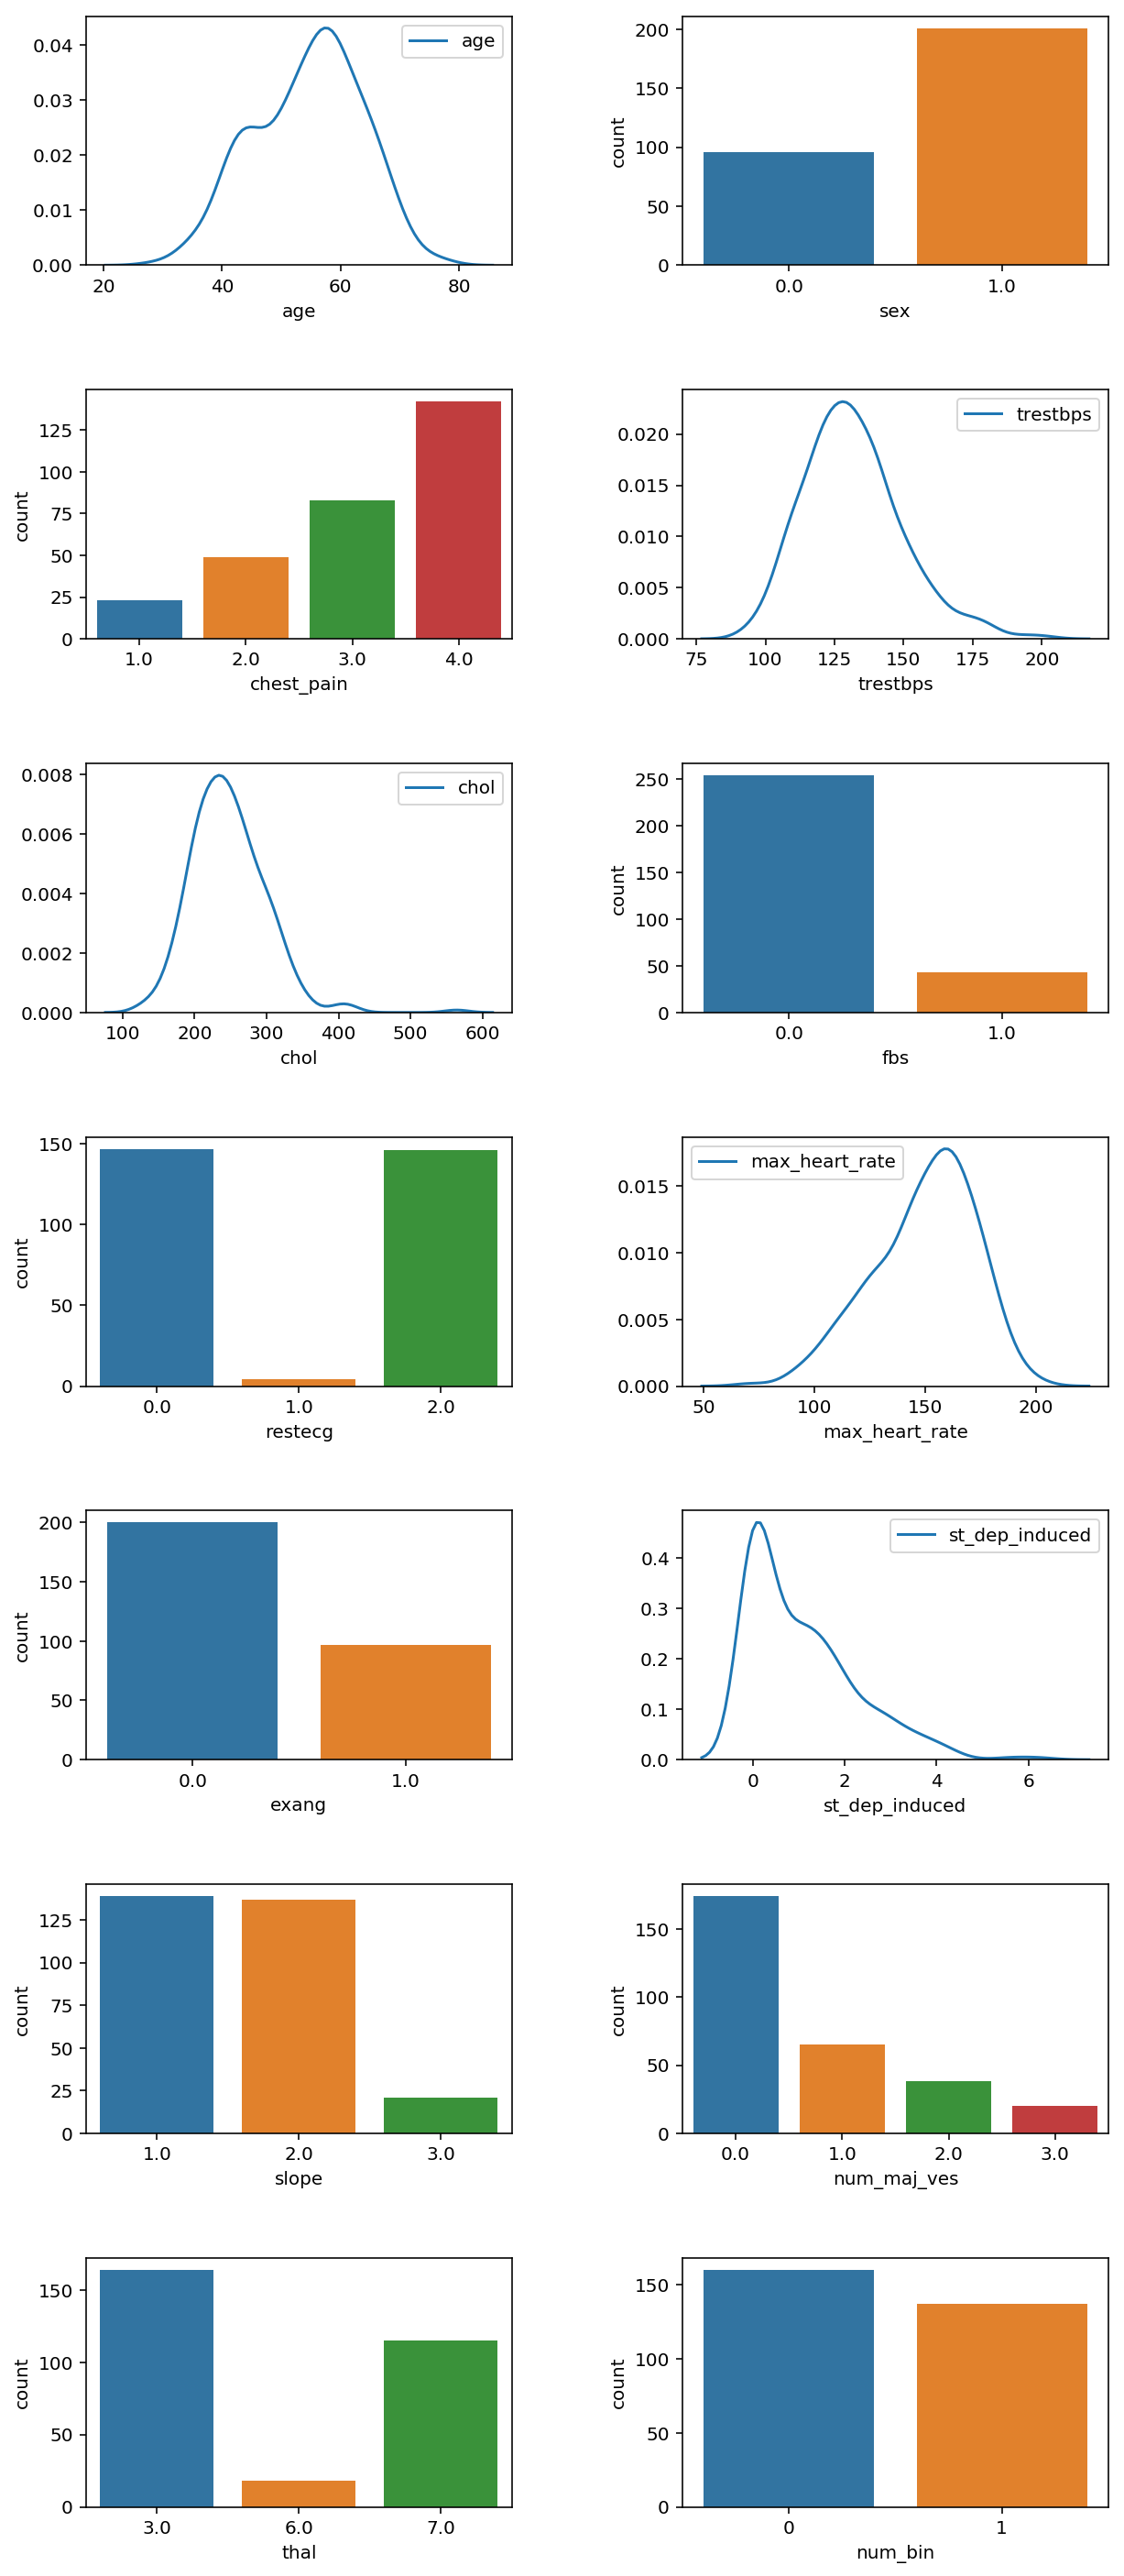

In [4]:
heart_df_plot = heart_df.copy()
heart_df_plot[["sex", "chest_pain", "fbs",
               "restecg", "exang", "slope",
               "num_maj_ves", "thal", "num_bin"]] = heart_df_plot[["sex", "chest_pain", "fbs", "restecg",
                                                                   "exang", "slope", "num_maj_ves", "thal", 
                                                                   "num_bin"]
                                                                 ].apply(lambda x: x.astype('category'))

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(10, 25))
ax = ax.reshape(-1)
plt.subplots_adjust(wspace=0.4, hspace=0.5)

for i, col in enumerate(heart_df_plot.columns):
    if heart_df_plot[col].dtype.name == "category":
        sns.countplot(x=col, data=heart_df_plot, ax=ax[i])
        ax[i].set_ylabel("count")
    else:
        sns.kdeplot(heart_df_plot[col], ax=ax[i])
    ax[i].set_xlabel(col)

### Correlations inbetween featues
Plotting the correlations inbetween features might help us to understand how the model will tie together later on.

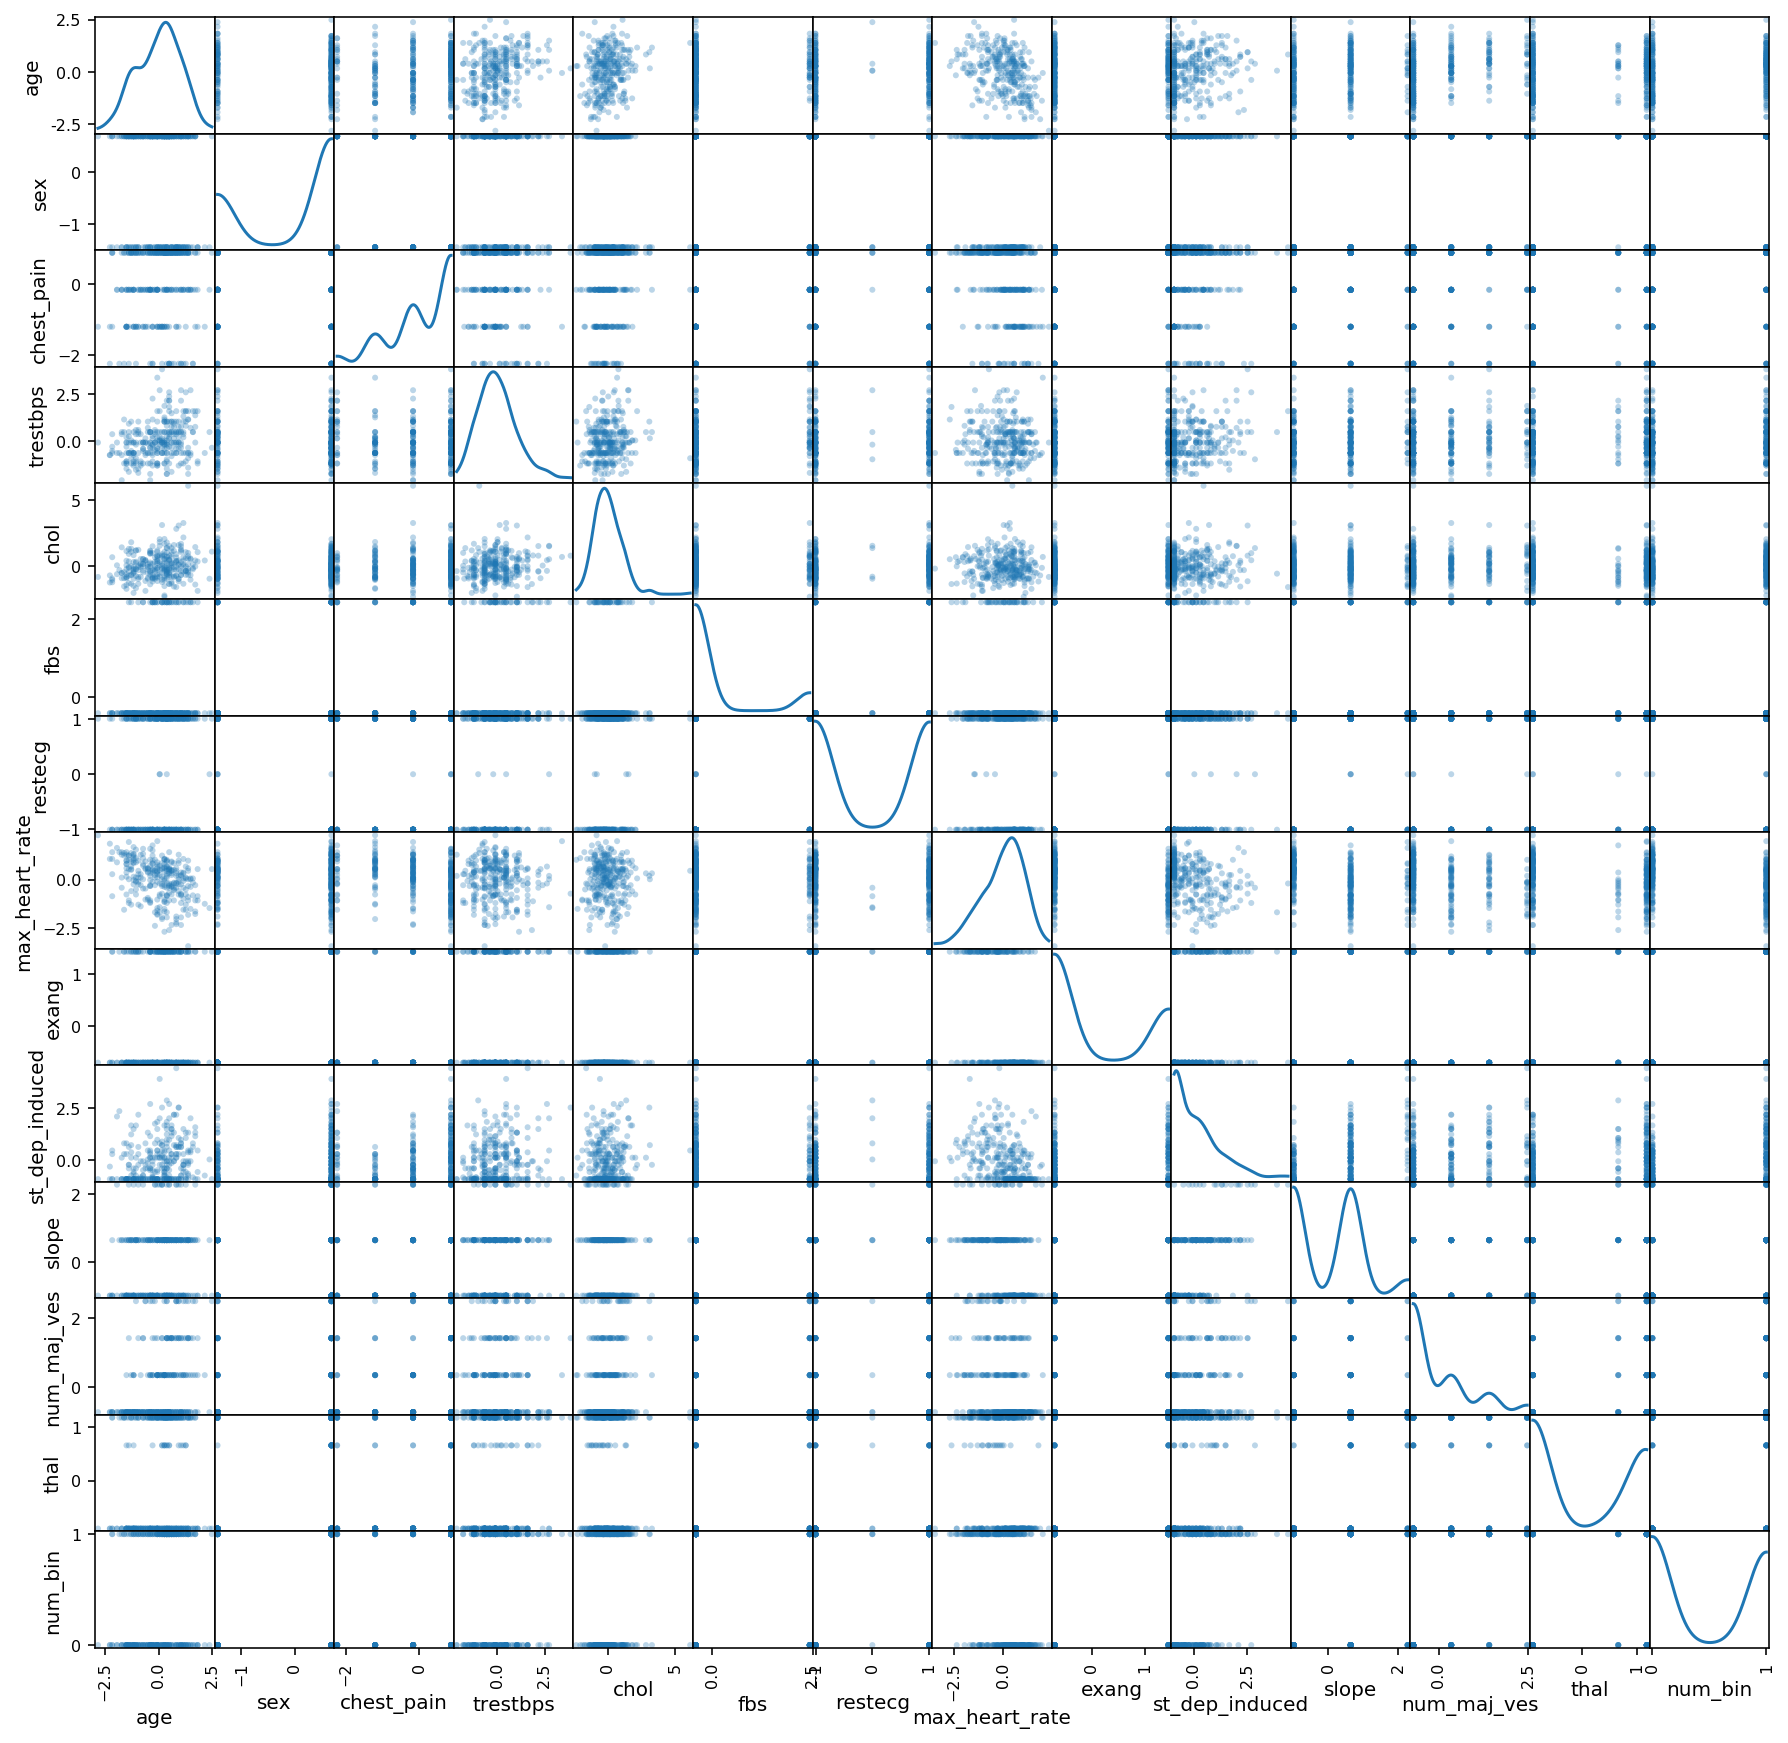

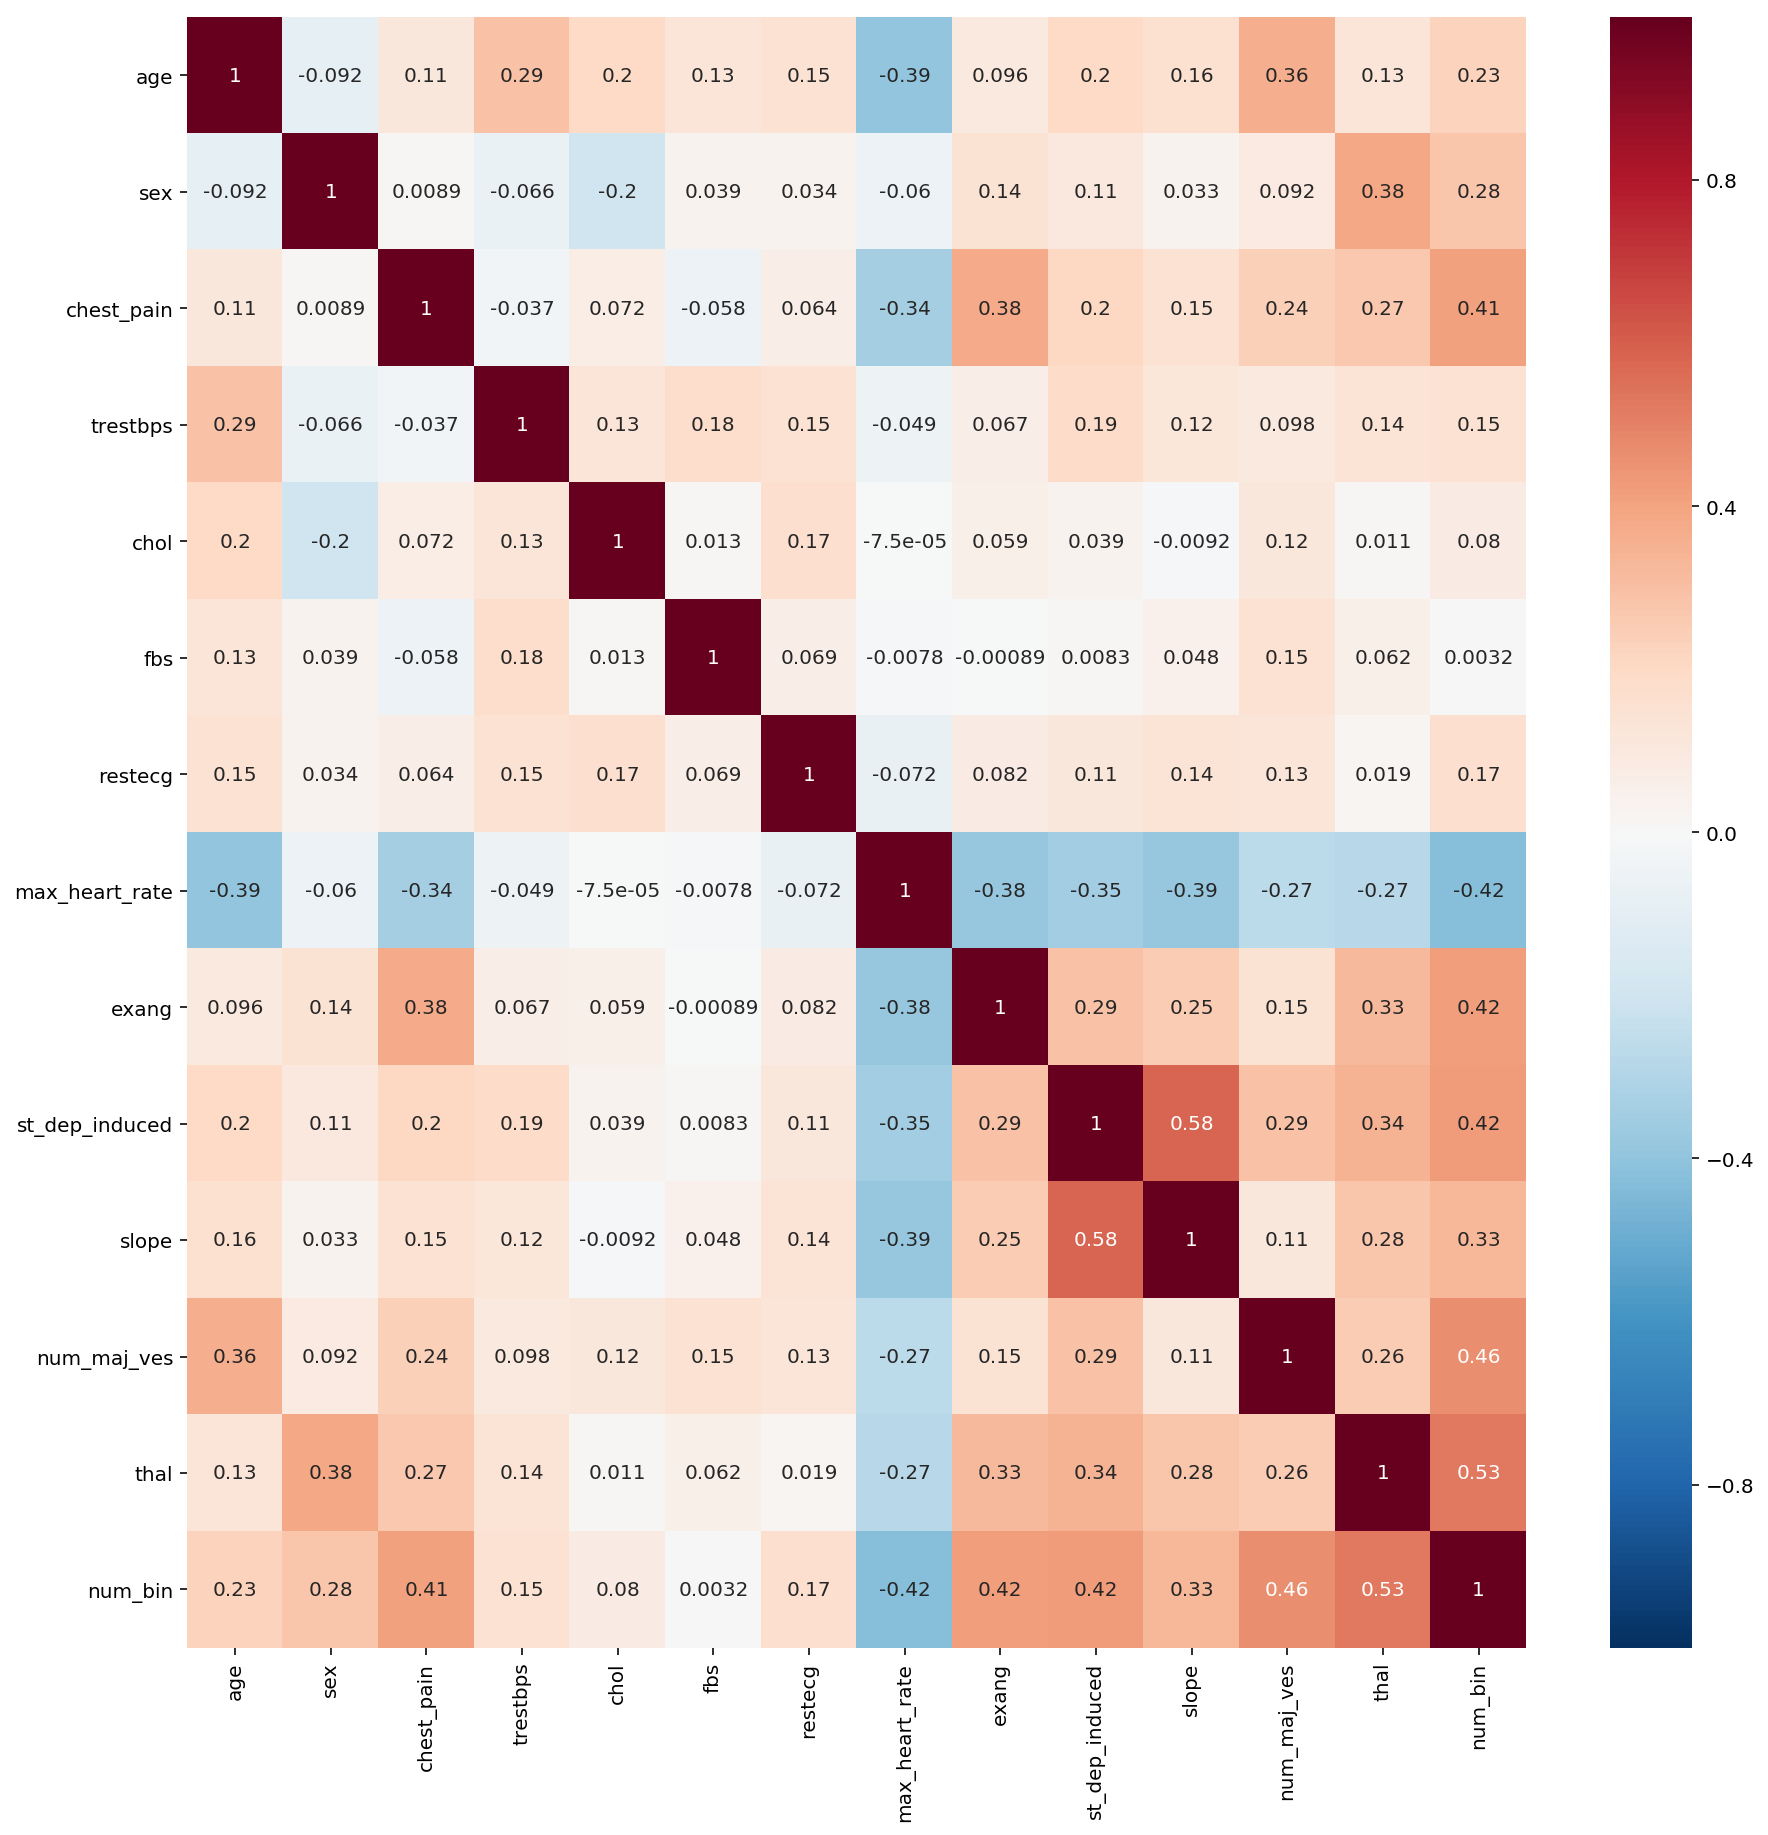

In [5]:
# Standardizing dataset
standardizing_heart_df = heart_df.copy()
scaler = preprocessing.StandardScaler()
# Checking out the scattered matrix
standardizing_heart_df.iloc[:, :-1] = scaler.fit_transform(heart_df.drop(['num_bin'], axis=1))
pd.plotting.scatter_matrix(standardizing_heart_df, alpha=0.3, figsize=(15,15), diagonal='kde');

# Checking our the heatmap of correlations
plt.figure(figsize=(15, 15))
correlation = standardizing_heart_df.corr(min_periods=10)
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")
plt.show()

## Building two models
We are going to focus only on two different models to illustrate the article. The first one is a classic highly interpretable machine learning model: **Random Forests**. While the second one is way less interpretable, arguably in the Deep Learning category: The **Multi Layer Perceptron**, one of the simplest neural networks.  

### Splitting the dataset
Before training these models, we will start by splitting the dataset into two different parts, the first part of the data will be used for training our models, while the second part will be used for testing them. It is really important to use the same testing set for both models as we want to be sure to be able to compare their performance accordingly.

In [6]:
# Using pytorch datasets to sample the sets into a
# well balanced training set, and a testing set
class HeartDataset(Dataset):
    def __init__(self, df, train=True):
        self.heart_df = df
        self.number_samples = len(df)
        self.train = train
    
    def __len__(self):
        return self.number_samples
    
    def __getitem__(self, idx):
        if not self.train:
            idx = torch.LongTensor([idx])
        features = self.heart_df.iloc[idx.item(), :-1]
        binary_class = self.heart_df.iloc[idx.item(), -1]
        return torch.FloatTensor(features.values), binary_class

# Keeping 90% of the dataset for training    
train_size = 0.9
train_sample_number = int(train_size*len(heart_df))

weight_one = 1 - sum(heart_df.iloc[:,-1]) / len(heart_df)
weight = [weight_one if c == 1 else 1 - weight_one for c in heart_df.iloc[:,-1] ]

total_dataset = HeartDataset(heart_df)
sampler = WeightedRandomSampler(weight, len(total_dataset), replacement=False)
batch_sampler = BatchSampler(sampler, train_sample_number, drop_last=False)

train_set, test_set = ([i.item() for i in cl] for cl in batch_sampler)
train_df = heart_df.iloc[train_set]
test_df = heart_df.iloc[test_set]
print("training set: {} samples, {:.2f}% of which belong to the first class".format(len(train_df), train_df.num_bin.value_counts().values[0] / len(train_df) * 100))
print("testing set: {} samples, {:.2f}% of which belong to the first class".format(len(test_df), test_df.num_bin.value_counts().values[0] / len(test_df) * 100))

training set: 267 samples, 53.56% of which belong to the first class
testing set: 30 samples, 56.67% of which belong to the first class


### Random Forest Classifier
The first model, Random Forests is highly interpretable which means that we can use it to predict the heart disease. But also understand **how** it was predicted by the model which is really valuable information for a doctor as it would help to pinpoint which factor is the most important in that regard.

We train the classifier with 5-fold grid search cross validation to find the best parameters for the model while  computing the accuracy, precision/recall/f1score over the folds.

In [7]:
train_features, train_targets = train_df.iloc[:,:-1], train_df.iloc[:,-1]
test_features, test_targets = test_df.iloc[:,:-1], test_df.iloc[:,-1]

rfc = RandomForestClassifier()

# The parameters we will test
parameters = {'n_estimators': list(range(5,40,5)),
              'max_features':list(range(2,13)),
              'max_depth': list(range(2,20))}
# We want the model to be fine tuned for recall more than the other metrics
recall_score = metrics.make_scorer(metrics.recall_score)

# Training for the best 
print("Grid Search via Cross validation:")
grid_search = GridSearchCV(rfc, parameters, scoring=recall_score, cv=5, n_jobs=3, verbose=1)
grid_search_fit = grid_search.fit(train_features, train_targets)
best_rfc = grid_search_fit.best_estimator_

# Testing the model
print("Testing the model on the testing set")
best_predict = best_rfc.predict(test_features)
print("\naccuracy :", metrics.accuracy_score(test_targets, best_predict))
print("recall :", metrics.recall_score(test_targets, best_predict))
print("precision :", metrics.precision_score(test_targets, best_predict))
print("f1 score :", metrics.f1_score(test_targets, best_predict), "\n")

# Importance of each feature
print("Here are all of the features ranked by importance in this prediction:")
feat_imp = [(list(heart_df)[i], feat) for i, feat in enumerate(best_rfc.feature_importances_)]
for name_feat, imp_feat in sorted(feat_imp,key=lambda x: x[1], reverse=True):
    print("{} : {}".format(name_feat, imp_feat))

Grid Search via Cross validation:
Fitting 5 folds for each of 1386 candidates, totalling 6930 fits


[Parallel(n_jobs=3)]: Done 462 tasks      | elapsed:    8.7s
[Parallel(n_jobs=3)]: Done 2262 tasks      | elapsed:   43.8s
[Parallel(n_jobs=3)]: Done 4494 tasks      | elapsed:  1.6min
[Parallel(n_jobs=3)]: Done 6594 tasks      | elapsed:  2.3min


Testing the model on the testing set

accuracy : 0.8
recall : 0.6153846153846154
precision : 0.8888888888888888
f1 score : 0.7272727272727274 

Here are all of the features ranked by importance in this prediction:
chest_pain : 0.1711427508645154
thal : 0.16168433731766313
num_maj_ves : 0.12027520695170384
st_dep_induced : 0.1008925109003321
chol : 0.09369152751018925
trestbps : 0.09237900185951871
age : 0.08974735483775738
max_heart_rate : 0.07778750348404853
slope : 0.04840346836248618
sex : 0.01618330829080174
exang : 0.014403474525647924
restecg : 0.013409555095335752
fbs : 0.0


[Parallel(n_jobs=3)]: Done 6930 out of 6930 | elapsed:  2.5min finished


So, we actually know which are the most important factors regarding the diagnosis made by our algorithm, as well as its performance.

Let's see now what it looks like when plotting the decision process of one of the decision trees:

In [8]:
# This piece of code was taken from this post:
#https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

# Extract a single tree of our classifier
# to check what it looks like
estimator = best_rfc.estimators_[0]

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = list(train_df.iloc[:, :-1]),
                class_names = ["Healthy", "Heart problem"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
Image(filename = 'tree.png')

So now, having this decision tree and the features' importances, we can go back to a doctor and provide the predictive model as well as the documentation explaining how the model makes its predictions. It is then easier for the doctor to understand what makes patients sick and how to solve the problem.

## Deep learning
### Multi Layer Perceptron
Now let us try out a deep learning method. The difference between them is that given enough features and samples for a single problem (hardly the case here), deep learning techniques should reach a higher accuracy/f1-score. Although they are way less interpretable which means that in our case, the tradeoff is quite difficult. Do we want to prioritize detecting the disease of undertsanding it to fix it ?

In [9]:
# Creating a validation set
train_nn_size = 0.9
fold_size = 0.2
train_nn_sample_number = int(train_nn_size*len(train_df))

weight_one = 1 - sum(train_df.iloc[:,-1]) / len(train_df)
weight = [weight_one if c == 1 else 1 - weight_one for c in train_df.iloc[:,-1] ]

# Standardizing training set
standardized_nn_train_df = train_df.copy()
scaler = preprocessing.StandardScaler()
scaler.fit(train_df.drop(['num_bin'], axis=1))
standardized_nn_train_df.iloc[:, :-1] = scaler.transform(train_df.drop(['num_bin'], axis=1))

# Sampling the dataset to have a training
# set representing 50% of each class
train_nn_set = HeartDataset(standardized_nn_train_df)
sampler = WeightedRandomSampler(weight, len(train_nn_set), replacement=False)
batch_sampler = BatchSampler(sampler, train_nn_sample_number, drop_last=False)

train_set, valid_set = ([i.item() for i in cl] for cl in batch_sampler)
train_nn_df = train_df.iloc[train_set]
valid_df = train_df.iloc[valid_set]
print("training set: {} samples, {:.2f}% of which belong to the first class".format(len(train_nn_df), train_nn_df.num_bin.value_counts().values[0] / len(train_nn_df) * 100))
print("validation set: {} samples, {:.2f}% of which belong to the first class".format(len(valid_df), valid_df.num_bin.value_counts().values[0] / len(valid_df) * 100))
print("testing set: {} samples, {:.2f}% of which belong to the first class".format(len(test_df), test_df.num_bin.value_counts().values[0] / len(test_df) * 100))

training set: 240 samples, 50.83% of which belong to the first class
validation set: 27 samples, 77.78% of which belong to the first class
testing set: 30 samples, 56.67% of which belong to the first class


In [10]:
# A few utility functions to build loaders, train a model and cross validate it
def precision(predictions, labels):
    """
    Computes the precision with regard to the given predictions and labels.
    Predictions and labels have to be boolean tables/series
    """
    predictions = np.array(predictions)
    labels = np.array(labels)
    
    true_positives = ((predictions == True) & (labels == True)).sum()
    false_positives =  ((predictions == True) & (labels == False)).sum()
    if true_positives == 0 and false_positives == 0:
        return 0
    return true_positives / (true_positives + false_positives)

def recall(predictions, labels):
    """
    Computes the recall with regard to the given predictions and labels.
    Predictions and labels have to be boolean tables/series
    """
    predictions = np.array(predictions)
    labels = np.array(labels)
    
    true_positives = ((predictions == True) & (labels == True)).sum()
    false_negatives =  ((predictions == False) & (labels == True)).sum()
    if true_positives == 0 and false_negatives == 0:
        return 0
    return true_positives / (true_positives + false_negatives)
    
def accuracy(predictions, labels):
    """
    Computes the accuracy with regard to the given predictions and labels.
    Predictions and labels have to be boolean tables/series
    """
    predictions = np.array(predictions)
    labels = np.array(labels)
    
    return (predictions == labels).sum() / len(predictions)

def f1_score(predictions, labels):
    """
    Computes the f1_score with regard to the given predictions and labels.
    Predictions and labels have to be boolean tables/series
    """
    predictions = np.array(predictions)
    labels = np.array(labels)
    
    prec = precision(predictions, labels)
    rec = recall(predictions, labels)
    return 2 * (prec * rec) / (prec + rec)

def f1_score_from_metrics(prec, rec):
    """
    Computes the f1_score with regard to the given precision and recall.
    Precision and Recall have to be the output of the precision
    and recall functions above
    """
    return 2 * (prec * rec) / (prec + rec)

def build_loaders(train_df, valid_df, test_df, batch_size=8):
    """
    Will build and return PyTorch data loaders to train and test the model
    """
    train_dataset = HeartDataset(train_nn_df)
    valid_dataset = HeartDataset(valid_df, train=False)

    # Do not forget to apply the same preprocessing to the testing set
    standardized_test_df = test_df.copy()
    standardized_test_df.iloc[:, :-1] = scaler.transform(test_df.drop(['num_bin'], axis=1))
    test_dataset = HeartDataset(standardized_test_df, train=False)

    weight_one = 1 - sum(train_nn_df.iloc[:,-1]) / len(train_nn_df)
    weight = [weight_one if c == 1 else 1 - weight_one for c in train_nn_df.iloc[:,-1] ]

    sampler = WeightedRandomSampler(weight, len(train_dataset))
    b_sampler = BatchSampler(sampler, batch_size, True)

    train_dataset_loader = DataLoader(dataset=train_dataset,  num_workers=0, batch_sampler=b_sampler )
    valid_dataset_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size)
    test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)
    
    return train_dataset_loader, valid_dataset_loader, test_dataset_loader

def train_model(model, train_dataset_loader, valid_dataset_loader, nb_epochs, regul=0):
    """
    Will train the model and retain the training and validation losses at each epoch
    """
    training_losses, validation_losses = [], []
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=regul)
    
    for e in range(nb_epochs):
        train_sum_loss = 0
        valid_sum_loss = 0
        
        model.train()
        for feat, c in train_dataset_loader:
            output = model(feat)
            loss = criterion(output, c)
            model.zero_grad()
            loss.backward()
            optimizer.step()
            train_sum_loss += loss.item()
            
        model.eval()
        for feat, c in valid_dataset_loader:
            output = model(feat)
            loss = criterion(output, c)
            valid_sum_loss += loss.item()
            
        if (e+1) % 100 == 0:
            print("epoch: {:4d}/{:4d} | training loss: {:3.4f} | validation loss: {:3.4f}".format(
                e+1, nb_epochs, normalized_train_loss, normalized_valid_loss))
            
        normalized_train_loss = train_sum_loss / len(train_dataset_loader)
        normalized_valid_loss = valid_sum_loss / len(valid_dataset_loader)
        training_losses.append(normalized_train_loss)
        validation_losses.append(normalized_valid_loss)
        
    plt.figure(figsize=(12, 8))
    plt.title("Training and validation losses")
    plt.plot(training_losses, 'red', label='training loss')
    plt.plot(validation_losses, 'green', label='validation loss')
    plt.legend(loc='best')
    plt.ylim(0, 1)
    plt.show()

def evaluate_model(model, dataset_loader, batch_size=8):
    """
    Will evaluate the model with a given test set and return the performance.
    """
    # Precision and f1-score
    model.eval()
    labels = []
    predictions = []
    
    for feat, c in dataset_loader:
        output = model(feat)
        _, predicted_classes = torch.max(output, 1)
        labels.extend(c)
        predictions.extend(predicted_classes)
        
    return accuracy(predictions, labels), precision(predictions, labels), recall(predictions, labels)

def test_model(model, train_dataset_loader, test_dataset_loader, nb_epochs, regul=0):
    """
    Will train the model and test it with the given training and testing set.
    """
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=regul)
    
    for e in range(nb_epochs):
        model.train()
        for feat, c in train_dataset_loader:
            output = model(feat)
            loss = criterion(output, c)
            model.zero_grad()
            loss.backward()
            optimizer.step()
            
        if (e+1) % 100 == 0:
            print("epoch: {:4d}/{:4d} | training loss: {:3.4f}".format(
                e+1, nb_epochs, loss))
            
    acc, prec, rec = evaluate_model(model, test_dataset_loader)
    f1_sc = 2 * prec * rec / (prec + rec)
    print("Testing set:\n\t- accuracy: {:2.2%}\n\t- precision: {:2.2%}\n\t- recall: {:2.2%}\n\t- f1-score: {:2.2%}\n"
          .format(acc, prec, rec, f1_sc))
            

def cv(train_df, model, l2_penalty, epochs, nb_folds=5):
    """
    Given a model and a training dataframe, this function will perform
    a cross-validation to check whether the model is stable or not.
    It will print the results when done.
    """
    total_accuracy_v = 0
    total_precision_v = 0
    total_recall_v = 0

    total_accuracy_t = 0
    total_precision_t = 0
    total_recall_t = 0
    
    

    for i in range(nb_folds):
        
        current_model = copy.deepcopy(model)
        fold_size = 0.2
        train_nn_index = int(fold_size*len(train_df))
        index_list = list(range(train_nn_index * i, train_nn_index * (i+1)))
        valid_index = train_df.index.isin(index_list)
        valid_df = train_df[valid_index]
        train_nn_df = train_df[~valid_index]
        print("training set: {} samples, {:.2f}% of which belong to the first class".format(len(train_nn_df), train_nn_df.num_bin.value_counts().values[0] / len(train_nn_df) * 100))
        print("validation set: {} samples, {:.2f}% of which belong to the first class".format(len(valid_df), valid_df.num_bin.value_counts().values[0] / len(valid_df) * 100))

        train_dataset_loader, valid_dataset_loader, test_dataset_loader = build_loaders(train_nn_df, valid_df, test_df)
        
        train_model(current_model, train_dataset_loader, valid_dataset_loader, epochs, l2_penalty)
        accuracy_valid, precision_valid, recall_valid = evaluate_model(current_model, valid_dataset_loader)
        accuracy_train, precision_train, recall_train = evaluate_model(current_model, train_dataset_loader)

        total_accuracy_v += accuracy_valid
        total_accuracy_t += accuracy_train

        total_precision_v += precision_valid
        total_precision_t += precision_train

        total_recall_v += recall_valid
        total_recall_t += recall_train

    mean_accuracy_v = total_accuracy_v / nb_folds
    mean_accuracy_t = total_accuracy_t / nb_folds

    mean_precision_v = total_precision_v / nb_folds
    mean_precision_t = total_precision_t / nb_folds

    mean_recall_v = total_recall_v / nb_folds
    mean_recall_t = total_recall_t / nb_folds


    mean_f1_score_t = f1_score_from_metrics(mean_precision_t, mean_recall_t)
    mean_f1_score_v = f1_score_from_metrics(mean_precision_v, mean_recall_v)
    print("Training set:\n\t- accuracy: {:2.2%}\n\t- precision: {:2.2%}\n\t- recall: {:2.2%}\n\t- f1-score: {:2.2%}\n"
          .format(mean_accuracy_t, mean_precision_t, mean_recall_t, mean_f1_score_t)) 
    print("Validation set:\n\t- accuracy: {:2.2%}\n\t- precision: {:2.2%}\n\t- recall: {:2.2%}\n\t- f1-score: {:2.2%}\n"
          .format(mean_accuracy_v, mean_precision_v, mean_recall_v, mean_f1_score_v))

Let us cross validate the model and see how it performs on a validation set, we want to be sure that it's consistent and robust depending on the samples given for training.

training set: 219 samples, 52.05% of which belong to the first class
validation set: 48 samples, 60.42% of which belong to the first class
epoch:  100/ 600 | training loss: 0.4707 | validation loss: 0.6068
epoch:  200/ 600 | training loss: 0.4135 | validation loss: 0.3975
epoch:  300/ 600 | training loss: 0.4537 | validation loss: 0.3421
epoch:  400/ 600 | training loss: 0.4371 | validation loss: 0.3205
epoch:  500/ 600 | training loss: 0.3219 | validation loss: 0.2569
epoch:  600/ 600 | training loss: 0.3818 | validation loss: 0.2823


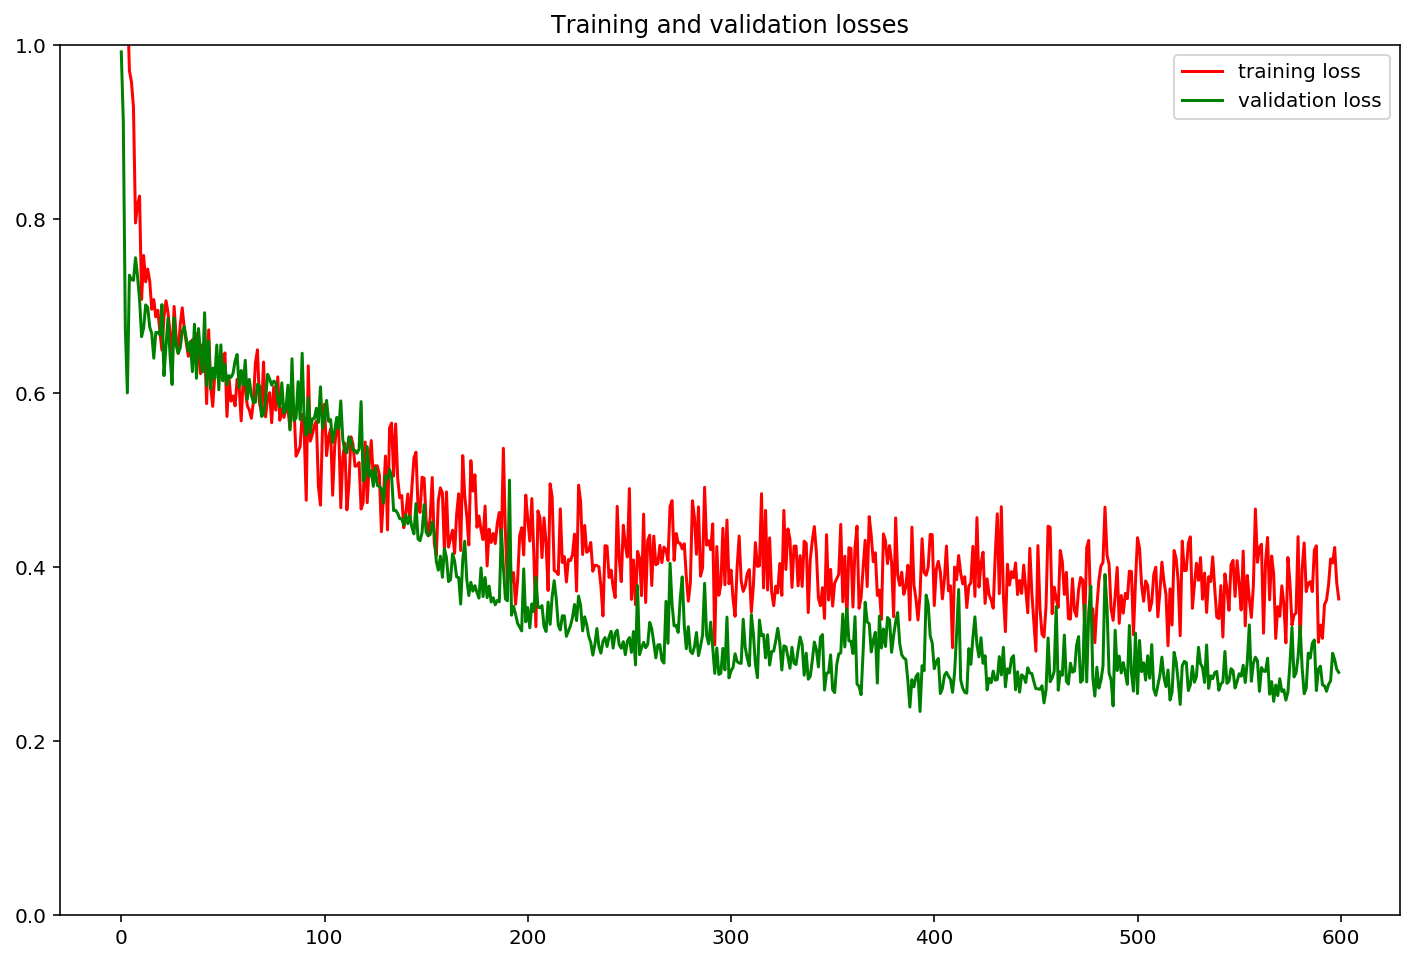

training set: 216 samples, 53.70% of which belong to the first class
validation set: 51 samples, 52.94% of which belong to the first class
epoch:  100/ 600 | training loss: 0.5604 | validation loss: 0.5181
epoch:  200/ 600 | training loss: 0.4092 | validation loss: 0.3397
epoch:  300/ 600 | training loss: 0.3895 | validation loss: 0.3383
epoch:  400/ 600 | training loss: 0.3758 | validation loss: 0.3223
epoch:  500/ 600 | training loss: 0.4286 | validation loss: 0.3220
epoch:  600/ 600 | training loss: 0.3578 | validation loss: 0.3291


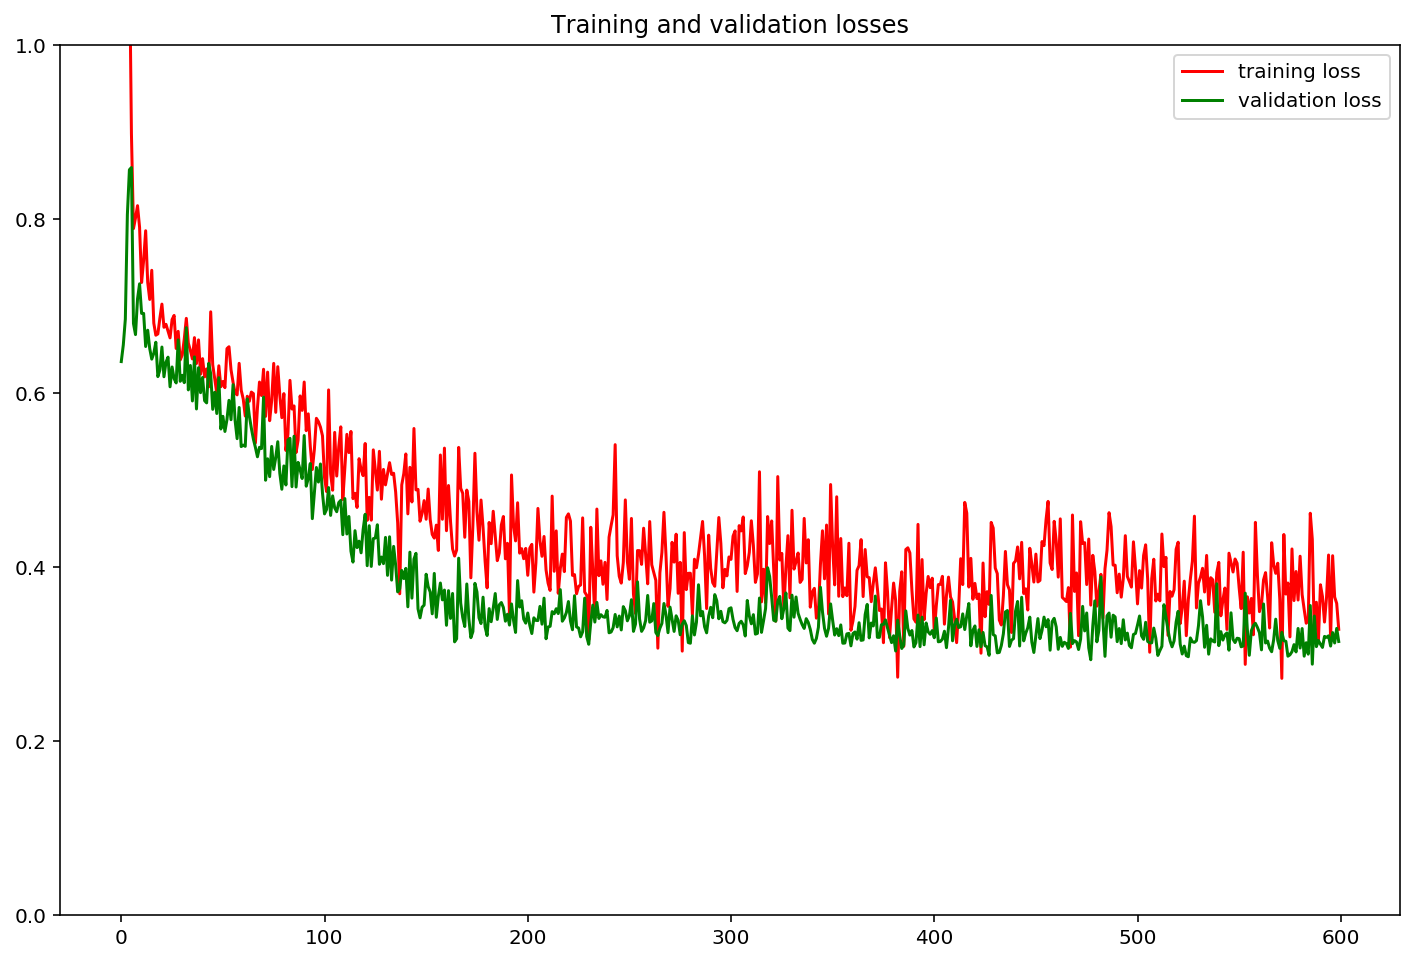

training set: 223 samples, 55.16% of which belong to the first class
validation set: 44 samples, 54.55% of which belong to the first class
epoch:  100/ 600 | training loss: 0.5775 | validation loss: 0.4365
epoch:  200/ 600 | training loss: 0.4091 | validation loss: 0.2726
epoch:  300/ 600 | training loss: 0.3802 | validation loss: 0.2919
epoch:  400/ 600 | training loss: 0.4514 | validation loss: 0.2403
epoch:  500/ 600 | training loss: 0.3800 | validation loss: 0.3236
epoch:  600/ 600 | training loss: 0.4084 | validation loss: 0.2411


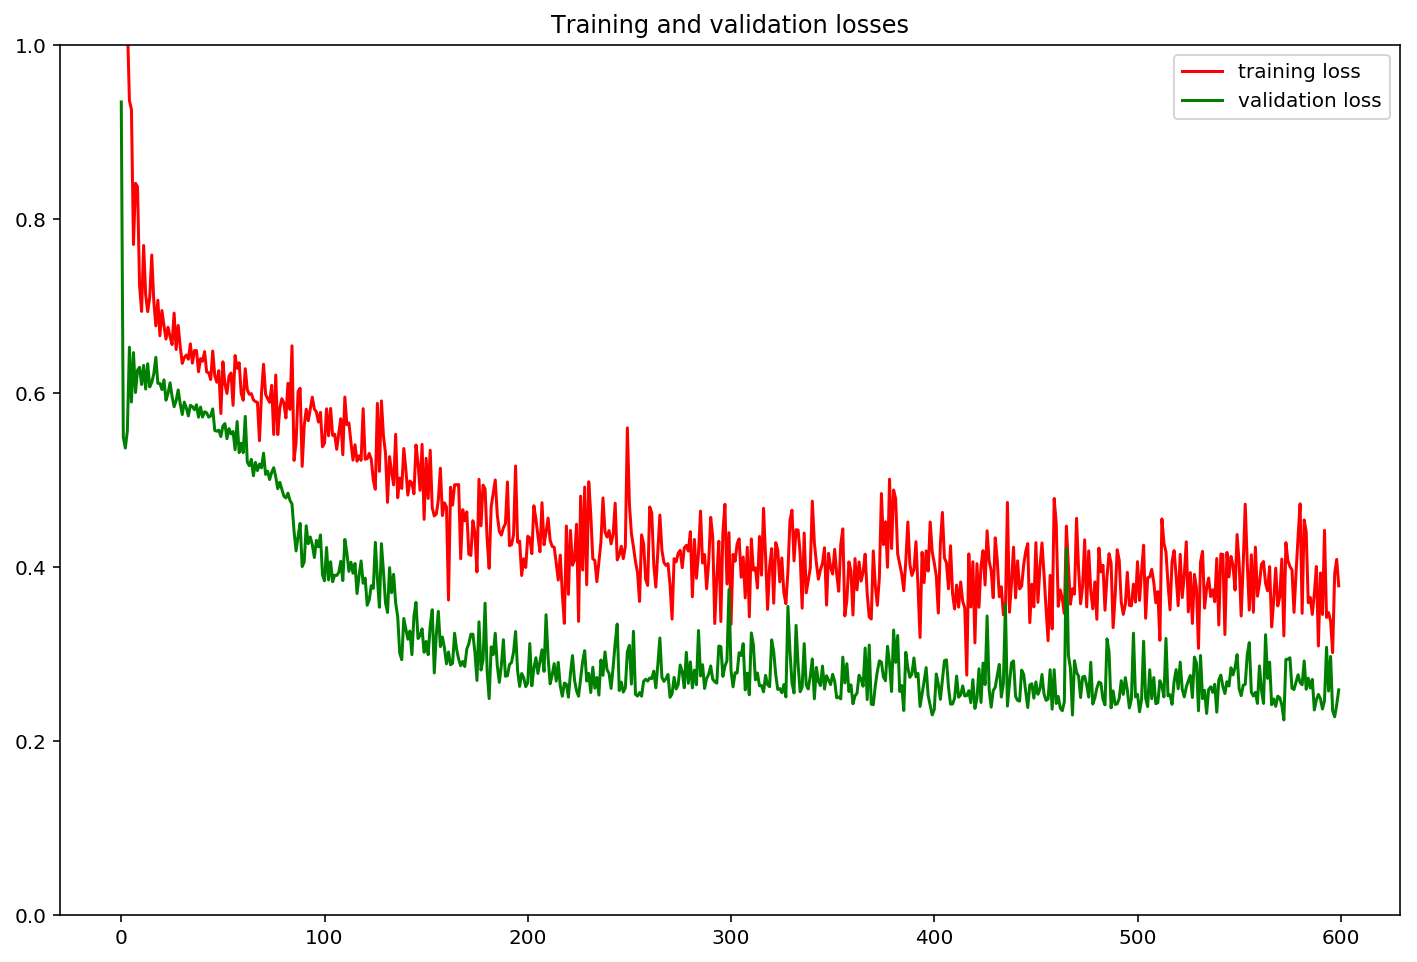

training set: 218 samples, 52.75% of which belong to the first class
validation set: 49 samples, 57.14% of which belong to the first class
epoch:  100/ 600 | training loss: 0.5683 | validation loss: 0.5536
epoch:  200/ 600 | training loss: 0.4222 | validation loss: 0.4417
epoch:  300/ 600 | training loss: 0.3459 | validation loss: 0.4030
epoch:  400/ 600 | training loss: 0.3924 | validation loss: 0.3767
epoch:  500/ 600 | training loss: 0.3122 | validation loss: 0.3808
epoch:  600/ 600 | training loss: 0.4124 | validation loss: 0.5257


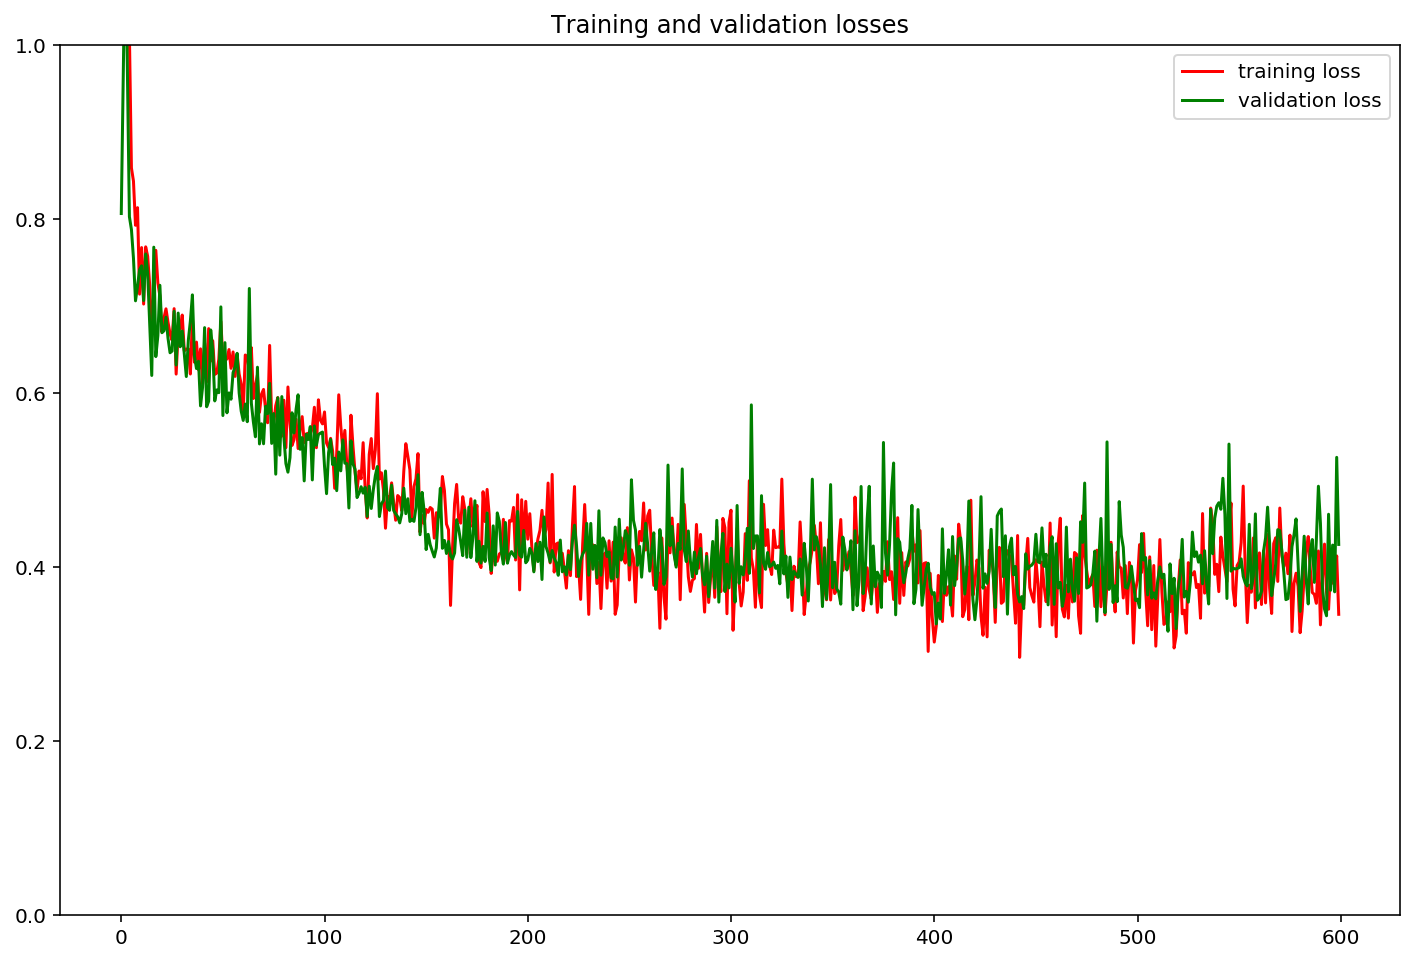

training set: 221 samples, 52.49% of which belong to the first class
validation set: 46 samples, 58.70% of which belong to the first class
epoch:  100/ 600 | training loss: 0.5428 | validation loss: 0.4885
epoch:  200/ 600 | training loss: 0.4384 | validation loss: 0.4087
epoch:  300/ 600 | training loss: 0.4057 | validation loss: 0.3858
epoch:  400/ 600 | training loss: 0.3518 | validation loss: 0.3855
epoch:  500/ 600 | training loss: 0.4368 | validation loss: 0.3557
epoch:  600/ 600 | training loss: 0.3595 | validation loss: 0.3587


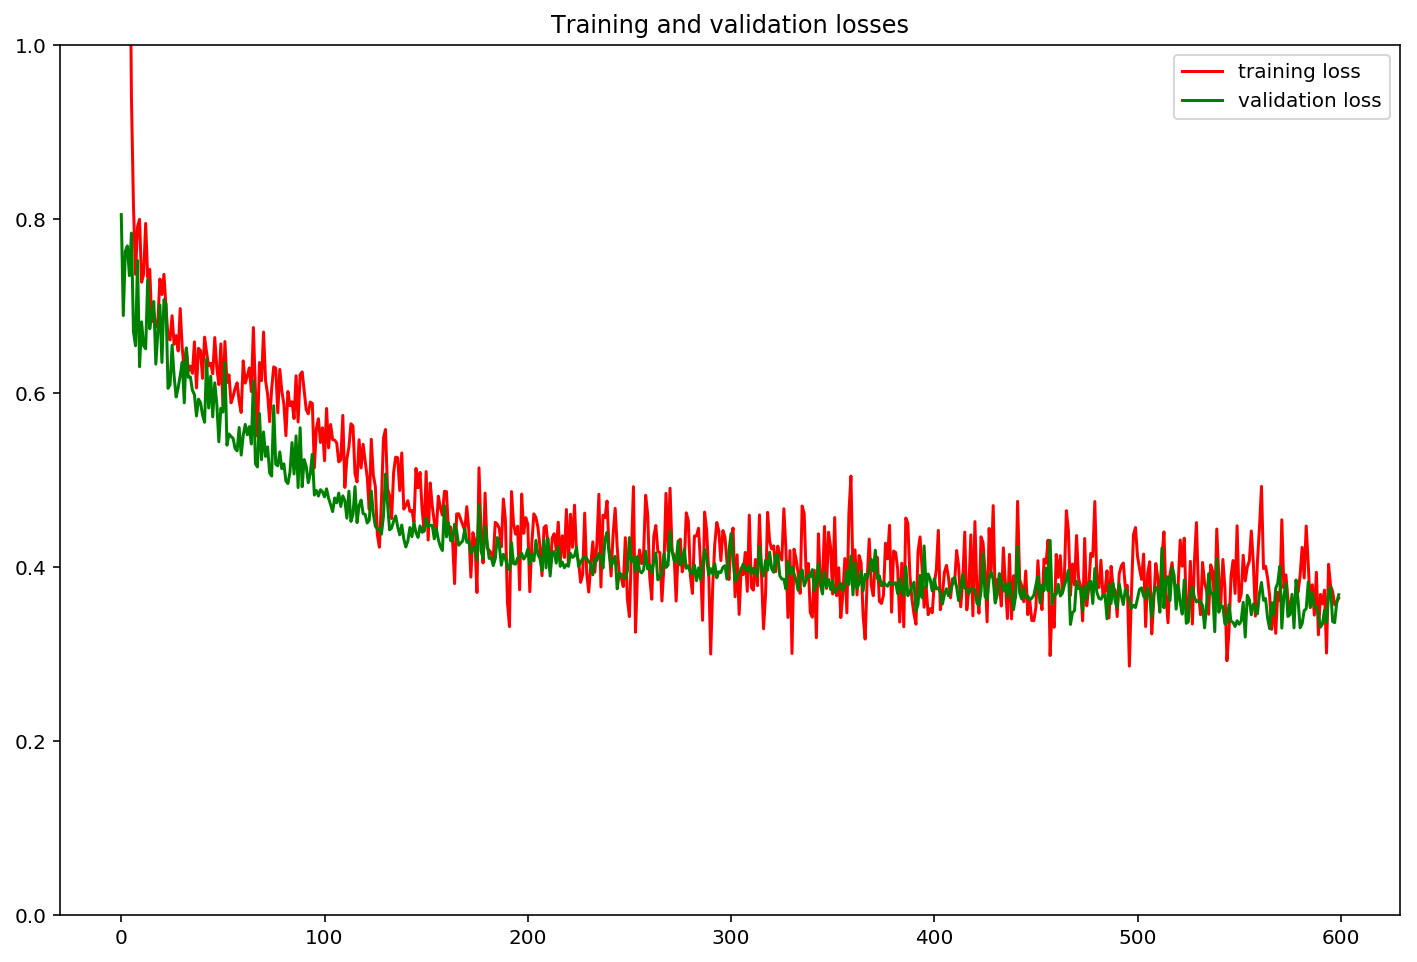

Training set:
	- accuracy: 85.67%
	- precision: 87.17%
	- recall: 84.08%
	- f1-score: 85.60%

Validation set:
	- accuracy: 84.92%
	- precision: 83.00%
	- recall: 82.77%
	- f1-score: 82.88%



In [11]:
drop = 0.2
model = torch.nn.Sequential(torch.nn.Linear(13,10),
                            torch.nn.Dropout(drop),
                            torch.nn.ReLU(),
                            torch.nn.Linear(10,5),
                            torch.nn.Dropout(drop),
                            torch.nn.ReLU(),
                            torch.nn.Linear(5,2))
cv(train_df, model, 0.00, 600)

Now that we know the modle is stable enough, we can simply train with the whole training set and test on the testing set.

In [12]:
epochs = 600
batch_size = 8
train_dataset = train_nn_set

# Do not forget to apply the same preprocessing to the testing set
standardized_test_df = test_df.copy()
standardized_test_df.iloc[:, :-1] = scaler.transform(test_df.drop(['num_bin'], axis=1))
test_dataset = HeartDataset(standardized_test_df, train=False)

weight_one = 1 - sum(train_nn_df.iloc[:,-1]) / len(train_nn_df)
weight = [weight_one if c == 1 else 1 - weight_one for c in train_nn_df.iloc[:,-1] ]

sampler = WeightedRandomSampler(weight, len(train_dataset))
b_sampler = BatchSampler(sampler, batch_size, drop_last=True)

train_dataset_loader = DataLoader(dataset=train_dataset,  num_workers=0, batch_sampler=b_sampler )
test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)
    
model = torch.nn.Sequential(torch.nn.Linear(13,10),
                            torch.nn.Dropout(drop),
                            torch.nn.ReLU(),
                            torch.nn.Linear(10,5),
                            torch.nn.Dropout(drop),
                            torch.nn.ReLU(),
                            torch.nn.Linear(5,2))

test_model(model, train_dataset_loader, test_dataset_loader, epochs)

epoch:  100/ 600 | training loss: 0.1912
epoch:  200/ 600 | training loss: 0.0618
epoch:  300/ 600 | training loss: 0.3418
epoch:  400/ 600 | training loss: 0.0354
epoch:  500/ 600 | training loss: 0.1014
epoch:  600/ 600 | training loss: 0.1255
Testing set:
	- accuracy: 86.67%
	- precision: 84.62%
	- recall: 84.62%
	- f1-score: 84.62%



As we can see, the neural network has better results compared to the Random forest model, however it is also way less interpretable, hence it's a tradeoff: better performance against interpretability. Do we **need** to know how a prediction was made, or do we want to make better predictions ? 